In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from glob import glob
import os
import shutil
from copy import deepcopy
from tqdm.notebook import tqdm

In [188]:
config = {}
WORK_DIR = os.getcwd()

# stylized characters creation
config["fake_image_dir"] = os.path.join(WORK_DIR, "gen_font", "fake_images")
config["mask_image_dir"] = os.path.join(WORK_DIR, "gen_font", "mask_images")
config["mask_created_dir"] = os.path.join(WORK_DIR, "gen_font", "mask_created")
config["mask_created_save_dir"] = os.path.join(WORK_DIR, "gen_font", "mask_created", "testB")
config["generated_chars_dir"] = os.path.join(WORK_DIR, "gen_font", "generated_chars")
config["exp_name"] = "font_generation_exp2"
config["font_family_path"] = os.path.join(WORK_DIR, "gen_font", "Unison-Pro-Light.ttf")
config["mask_size"] = 400
config["font_size"] = 352
config["right_padding"] = 20
config["bottom_padding"] = 30
config["transform_prob"] = 0.3


### Character Mask Creation

In [189]:
import random
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

random.seed(44)

# we are at /content/pytorch-CycleGAN-and-pix2pix !!

def create_character_mask(char, pic_index, config):
    image = Image.new("RGB", (config["mask_size"], config["mask_size"]), "black")
    font = ImageFont.truetype(config["font_family_path"], config["font_size"])
    draw = ImageDraw.Draw(image)
    
    # save created mask
    if not os.path.exists(config["mask_created_save_dir"]):
        os.makedirs(config["mask_created_save_dir"], exist_ok=True)
   
    draw.text((10, 10), char, fill="white", font=font, align="left")  # draw text mask
    image.save(os.path.join(config["mask_created_save_dir"], f"{pic_index}_{char}.png")) # save


def mask_transform(config):
    for image_path in sorted(glob(os.path.join(config["mask_created_save_dir"], "*"))):
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply erosion
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # Adjust the kernel size as needed
        eroded = cv2.erode(gray, kernel, iterations=3)
        eroded_rgb = cv2.cvtColor(eroded, cv2.COLOR_GRAY2RGB)
        
        # Save the eroded image (overwrite the original)
        cv2.imwrite(image_path, eroded_rgb)


def get_character_masks(text, config):
    # create each character mask
    characters = list(text)
    for i in range(len(characters)):
        create_character_mask(char=characters[i], pic_index=i, config=config)

    # Apply some transform >> erode only for now
    probability = config["transform_prob"]
    random_number = random.random()
    if random_number < probability:
        mask_transform(config)
    
    # get stylized result images >>> must add no dropout !!!!!
    # please use single quote '' inside doubke quote
    os.system(f"python test.py --dataroot {config['mask_created_dir']} --direction BtoA --checkpoints_dir ./gen_font/checkpoints/ --name {config['exp_name']} --results_dir {config['generated_chars_dir']} --preprocess scale_width_and_crop --load_size {config['mask_size']} --crop_size {config['mask_size']} --num_test {len(characters)} --model test --no_dropout")
    
    # remove existing used images in dataset - testB
    for i in glob(os.path.join(config["mask_created_save_dir"], "*")):
        os.remove(i)

In [82]:
get_character_masks("8A017", config)

  0%|          | 0/5 [00:00<?, ?it/s]

### Character Insertion

In [190]:
def get_mask(mask_path):
    mask = np.array(Image.open(mask_path).convert("RGB"), dtype=np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, thresh_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Apply morphological dilation to make the mask bigger to cover more detail of the fake image result
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(thresh_mask, kernel, iterations=3)
    return dilated_mask


def get_encapsulate_box(dilated_mask):
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return x, y, w, h


def get_augmented_character(fake_image_path, mask_path):
    fake_image = np.array(Image.open(fake_image_path).convert("RGB"), dtype=np.uint8)
    mask = get_mask(mask_path) # dilated_mask
    masked = cv2.bitwise_and(fake_image, fake_image, mask=mask)
    x, y, w, h = get_encapsulate_box(mask)
    # result in dictionary
    augmented_character = {"fake_image":fake_image, "bw_mask":mask, "masked": masked, "encapsulate_bbox":[x, y, w, h]}
    return augmented_character


def get_text_box_size(augmented_characters, total_char=5, char_padding=30):
    """
    Calculate The Total area used to place 5 selected characters
    """
    widths, heights = [], []
    for augmented_character in augmented_characters:
        x,y,w,h = augmented_character["encapsulate_bbox"]
        widths.append(w)
        heights.append(h)
    width = sum(widths) + char_padding*(total_char-1)
    height = max(heights)
    return (width, height)


def get_cropped_character(augmented_characters, char_index):
    """
    get the cropped version of bw_mask & masked on a single character
    """
    x,y,w,h = augmented_characters[char_index]["encapsulate_bbox"]
    bw_mask = augmented_characters[char_index]["bw_mask"]
    cropped_bw_mask = bw_mask[y:y+h, x:x+w]
    masked = augmented_characters[char_index]["masked"]
    cropped_masked = masked[y:y+h, x:x+w]
    return cropped_bw_mask, cropped_masked


def get_paired_cropped_characters(augmented_characters):
    """
    get list of cropped version of bw_mask & masked on all characters in augmented_characters
    """
    cropped_bw_masks = []
    cropped_masked_s = []
    for char_index in range(len(augmented_characters)):
        cropped_bw_mask, cropped_masked = get_cropped_character(augmented_characters, char_index)
        cropped_bw_masks.append(cropped_bw_mask)
        cropped_masked_s.append(cropped_masked)
    return cropped_bw_masks, cropped_masked_s


def add_obj(background, img, mask, x, y):
    '''
    Arguments:
    background - background image in CV2 RGB format
    img - image of object in CV2 RGB format
    mask - mask of object in GRAY-SCALE format
    x, y - coordinates of the top-left of the object image
    0 < x < width of background
    0 < y < height of background

    Function returns background with added object in CV2 RGB format !!!! RGB !!!!
    CV2 RGB format is a numpy array with dimensions width x height x 3
    '''
    bg = background.copy()
    # width & height of the text box
    h_bg, w_bg = bg.shape[0], bg.shape[1]

    # width & height of the character mask
    h, w = img.shape[0], img.shape[1]

    mask_boolean = mask[:,:,0] == 255 # black == True !!!!!!
    mask_rgb_boolean = np.stack([mask_boolean, mask_boolean, mask_boolean], axis=2)

    # REQUIRED: x >= 0 and y >= 0
    # place single character on text box
    # x,y = top-left coordinate !!!!
    h_part = h - max(0, y+h-h_bg) # h_part - part of the image which overlaps background along y-axis
    w_part = w - max(0, x+w-w_bg) # w_part - part of the image which overlaps background along x-axis
    bg[y:y+h_part, x:x+w_part, :] = bg[y:y+h_part, x:x+w_part, :] * ~mask_rgb_boolean[0:h_part, 0:w_part, :] + (img * mask_rgb_boolean)[0:h_part, 0:w_part, :]
    return bg


def create_text_box(augmented_characters, char_padding=30):
    """
    output the merged characters to be a single text box containing 5 characters
    output will be (text box of masked_s, text box of bw_masks)
    """
    # get the text box canva
    text_box_w, text_box_h = get_text_box_size(augmented_characters,
                                           total_char=len(augmented_characters),
                                           char_padding=char_padding) # !!
    text_box_image = np.zeros((text_box_h, text_box_w, 3), dtype=np.uint8)
    # get text box for both text_box_masked & text_box_bw_mask
    text_box_masked = text_box_image.copy()
    text_box_bw_mask = text_box_image.copy()
    # size of text box, same for both text_box_masked & text_box_bw_mask
    h_bg, w_bg = text_box_image.shape[0], text_box_image.shape[1]

    # get masks & masked_s
    cropped_bw_masks, cropped_masked_s = get_paired_cropped_characters(augmented_characters)

    """
    Each character will be placed next to each on the right + have "char_padding" distance to each
    So we need to calculate the top-left coordinates to correctly place each character
    """
    # start calculate top-left coordinate - first character top-left will be at (0,0)
    x = 0
    y = 0 # this will be fixed cause we shift character through x-axis

    for index, (bw_mask, masked) in enumerate(zip(cropped_bw_masks, cropped_masked_s)):
        """
        masked  = stylized character image
        bw_mask = black-white character mask
        """
        # get width & height of the character
        h, w = bw_mask.shape[0], bw_mask.shape[1]
        # convert bw_mask to rgb before use
        bw_mask = cv2.cvtColor(bw_mask, cv2.COLOR_GRAY2RGB)
        # place on bg_masked
        text_box_masked = add_obj(text_box_masked, masked, bw_mask, x, y)
        # place on bg_bw_mask
        text_box_bw_mask = add_obj(text_box_bw_mask, bw_mask, bw_mask, x, y)

        # get correct top-left coordinate for the next character
        if index < len(cropped_bw_masks)-1:
            x = x + w + char_padding
            
    return text_box_masked, text_box_bw_mask


def get_insert_area(bg_image):
    """
    to return coordinates of the mask insertion area for placing text box containing fake characters
    Step: thresholding + find largest contour + get coordinates
    >> Input: Non-character Background image
    >> Output: (largest contour coordinates, top-left & bottom-right of mask insertion area)
    """
    # Otsu
    if isinstance(bg_image, str): # image path
        image = cv2.imread(bg_image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(bg_image, np.ndarray):
        image = bg_image # image array
    else:
        print("Failed")
        return None

    # Otsu thresholding
    _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find the largest contour by sorting contours based on area
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the rectangle that encapsulate the largest contour = Mask Insertion Area
    x, y, w, h = cv2.boundingRect(largest_contour)
    bounding_rect_contour = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.int32)

    # get top-left & bottom-right of mask insertion area
    placable_topleft = bounding_rect_contour[0]
    placable_bottomright = bounding_rect_contour[2]
    return largest_contour, placable_topleft, placable_bottomright


def get_random_coordinate(placable_topleft, placable_bottomright, text_box_masked):
    x1,y1 = placable_topleft
    x2,y2 = placable_bottomright
    h, w = text_box_masked.shape[:-1]
    # find range that is able to randomly place the top-left coordinate of text box on the background image
    # range for top-left only
    random_width_range = (x1, x2-w)
    random_height_range = (y1, y2-h)

    random_x = random.randint(random_width_range[0], random_width_range[1])
    random_y = random.randint(random_height_range[0], random_height_range[1])

    return (random_x, random_y)

# bg_image input of this funciton will be [ gray-scale ] !!!!
def randomly_place_text_box(bg_image, text_box_masked, text_box_bw_mask):
    # get_insert_area needs bg to be gray-scale
    _, placable_topleft, placable_bottomright = get_insert_area(bg_image)
    random_x, random_y = get_random_coordinate(placable_topleft, placable_bottomright, text_box_masked)

    # add_obj need bg to be rgb
    bg_image = cv2.cvtColor(bg_image, cv2.COLOR_GRAY2RGB)
    result_image = add_obj(bg_image, text_box_masked, text_box_bw_mask, random_x, random_y)
    return result_image, (random_x, random_y)

In [191]:
# bounding box extraction & save output part

def get_character_boxes_xywh(augmented_characters, start_point, char_padding):
    x, y = start_point
    bboxes = []
    for index, char in enumerate(augmented_characters):
        _,_,w,h = augmented_characters[index]['encapsulate_bbox']
        bboxes.append([x, y, w, h]) # top-left, width, height of single character
        # add up each character
        if index < len(augmented_characters)-1:
            x = x + w + char_padding
    return bboxes


def save_result(config, all_output, pic_no, text):
    # create directories to save
    os.makedirs(os.path.join(config["results_dir"]), exist_ok=True)
    result_image_dir = os.path.join(config["results_dir"], "images")
    result_annotation_dir = os.path.join(config["results_dir"], "annotations") 
    os.makedirs(result_image_dir, exist_ok=True) # result images dir
    os.makedirs(result_annotation_dir, exist_ok=True) # result annotation dir
    
    # save image - name as {pic_no}_{text}.png
    cv2.imwrite(os.path.join(result_image_dir, f"{pic_no}_{text}.png"), all_output['result_image'])

    # save bbox as text file - name as {pic_no}_{text}.txt
    # format = "class_name x y w h \n class_name x y w h \n ...]
    annotation = ""
    text_annot = f"text_box {' '.join(str(item) for item in all_output['text_box_xywh'])}\n"
    annotation = annotation + text_annot
    for char_box in all_output["char_boxes_xywh"]:
        char_annot = f"char_box {' '.join(str(item) for item in char_box)}\n"
        annotation = annotation + char_annot
        
    with open(os.path.join(result_annotation_dir, f"{pic_no}_{text}.txt"), "w") as file:
        file.write(annotation)

In [251]:
import traceback

# place generated characters to non-character background
config["generated_chars_image_dir"] = os.path.join(config['generated_chars_dir'], config['exp_name'],
                                                   "test_latest", "images")
config["background_image_path"] = os.path.join(WORK_DIR, "gen_font", "(3)8Z003_2_hard_mask.png")
config["char_padding"] = 50
config["results_dir"] = os.path.join(WORK_DIR, "gen_font", "results")


def get_augment_image(text, pic_no, config): # ex: text="8A017"
    # >>> mask creation Implementation <<<
    get_character_masks(text, config)

    # >>> Insertion Implementation <<<
    fake_image_paths = sorted(glob(os.path.join(config["generated_chars_image_dir"], "*fake*")))
    mask_paths = sorted(glob(os.path.join(config["generated_chars_image_dir"], "*real*")))
    bg_image = np.array(Image.open(config["background_image_path"]).convert("L"))

    try:
        # get info needed of each single character
        augmented_characters = []
        for i, (fake_image_path, mask_path) in enumerate(zip(fake_image_paths, mask_paths)):
            augmented_character = get_augmented_character(fake_image_path, mask_path)
            augmented_characters.append(augmented_character)

        # get text box masked & bw_mask
        text_box_masked, text_box_bw_mask = create_text_box(augmented_characters, 
                                                            char_padding=config["char_padding"])
        # get enable-to-place area on the non-character background image
        largest_contour, placable_topleft, placable_bottomright = get_insert_area(bg_image)
        
        # randomly place text box on the non-character background image & get result
        result_image, (random_x, random_y) = randomly_place_text_box(bg_image, text_box_masked, text_box_bw_mask)

        # get bounding box of each character and get bbox of text box
        start_point = (random_x, random_y)
        text_box_h, text_box_w = text_box_masked.shape[:-1]
        text_box_xywh = [random_x, random_y, text_box_w, text_box_h]
        char_boxes_xywh = get_character_boxes_xywh(augmented_characters, start_point, config["char_padding"])

        # save result image & save annotated bbox of text box & each character
        all_output = {"result_image":result_image, "text_box_xywh":text_box_xywh, "char_boxes_xywh":char_boxes_xywh}
        save_result(config, all_output, pic_no, text)
        # print("generate and save successfully ...")
        
    except Exception as e:
        print(f"Error at {pic_no}_{text}: {e}")
        print(traceback.print_exc())
        return ""

    #  clear generated characters
    for i in glob(os.path.join(config["generated_chars_image_dir"], "*")):
        os.remove(i)
    
    return result_image

In [252]:
import random

random.seed(44)

def get_random_text():
    first_position = "0123456789"
    second_position = "AHKZP"
    rest_positions = "0123456789"
    
    # Generate a random text according to the specified pattern
    random_text = random.choice(first_position) + random.choice(second_position) + \
                  ''.join(random.choice(rest_positions) for _ in range(3))
    return random_text

get_random_text()

'6P812'

In [248]:
shutil.rmtree("./gen_font/generated_chars")
shutil.rmtree("./gen_font/mask_created")
shutil.rmtree("./gen_font/results")

In [253]:
# implement NOWWWW YEAHHHHHH!!H!HH!H!H!HH!H!
import time
start_time = time.time()

for i in tqdm(range(1700)):
    # random text
    text = get_random_text()
    # gen
    result_image = get_augment_image(text=text, pic_no=i, config=config)
    
print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/1700 [00:00<?, ?it/s]

--- 7907.85285282135 seconds ---


### Test test test

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

generate and save successfully ...


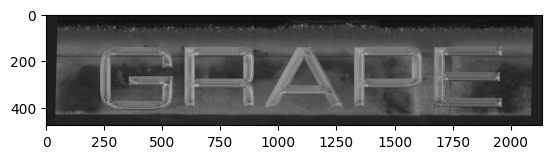

In [174]:
result_image = get_augment_image(text="GRAPE", pic_no=0, config=config)
plt.imshow(result_image)

Error at 0_4H008: empty range for randrange() (338, 268, -70)
None


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_9796\1106521985.py", line 34, in get_augment_image
    result_image, (random_x, random_y) = randomly_place_text_box(bg_image, text_box_masked, text_box_bw_mask)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_9796\1993892124.py", line 198, in randomly_place_text_box
    random_x, random_y = get_random_coordinate(placable_topleft, placable_bottomright, text_box_masked)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_9796\1993892124.py", line 189, in get_random_coordinate
    random_x = random.randint(random_width_range[0], random_width_range[1])
  File "C:\Users\User\anaconda3\envs\pytorch-CycleGAN-and-pix2pix\lib\random.py", line 248, in randint
    return self.randrange(a, b+1)
  File "C:\Users\User\anaconda3\envs\pytorch-CycleGAN-and-pix2pix\lib\random.py", line 226, in randrange
    raise ValueError("empty range for randrange() (%d, %d, %d)" % (istart, istop, width))
ValueError: empty range f

TypeError: Image data of dtype <U1 cannot be converted to float

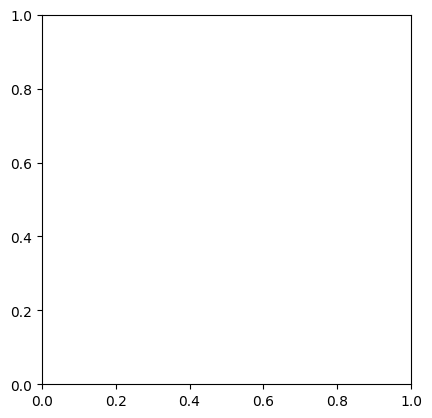

In [245]:
# test with another background
config["background_image_path"] = os.path.join(WORK_DIR, "gen_font", "(3)8Z020_1_extreme_mask.png")
config["char_padding"] = 70

result_image = get_augment_image(text="4H008", pic_no=0, config=config)
plt.imshow(result_image)

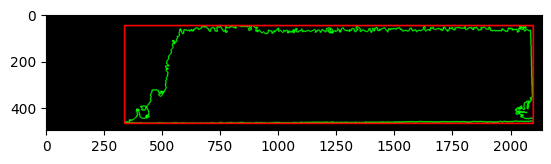

In [247]:
# !!! Alert !!!
bg_image = np.array(Image.open('./gen_font/(3)8Z020_1_extreme_mask.png').convert('L'))
_, binary_mask = cv2.threshold(bg_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = np.ones((5,5), np.uint8) # structure element
opened_image = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
dilated_image = cv2.dilate(opened_image, kernel, iterations=3)

# Load the masked black and white image (thresholded mask)
largest_contour, (x1,y1), (x2,y2) = get_insert_area(bg_image)

# Draw all contours on a blank image for visualization (optional)
contour_image = np.zeros_like(bg_image)
contour_image = cv2.cvtColor(contour_image, cv2.COLOR_GRAY2RGB)
cv2.drawContours(contour_image, [largest_contour], -1, [0,255,0], 3)  # Draw large contours
cv2.drawContours(contour_image, [np.array([[[x1, y1]], [[x2, y1]], [[x2, y2]], [[x1, y2]]])], -1, [255,0,0], 6)
plt.imshow(contour_image)
plt.show()

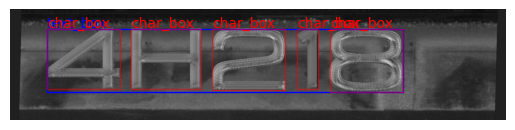

In [169]:
### Chek correctness - ok

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image_path = "./gen_font/results/images/0_4H218.png"

with open("./gen_font/results/annotations/0_4H218.txt", "r") as file:
    lines = file.readlines()


image = Image.open(image_path)
fig, ax = plt.subplots()
for line in lines:
    data = line.split()
    class_name = data[0]
    x, y, w, h = map(int, data[1:])
    if class_name == "text_box":
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, class_name, fontsize=10, color='b')
    else:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', alpha=0.5, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, class_name, fontsize=10, color='r')
ax.imshow(image)
plt.axis('off')
plt.show()

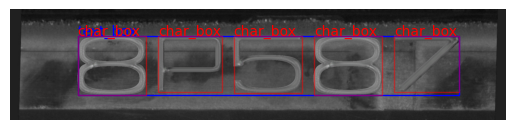

In [206]:
### Chek correctness - ok

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image_path = "./gen_font/results/images/0_8P587.png"

with open("./gen_font/results/annotations/0_8P587.txt", "r") as file:
    lines = file.readlines()


image = Image.open(image_path)
fig, ax = plt.subplots()
for line in lines:
    data = line.split()
    class_name = data[0]
    x, y, w, h = map(int, data[1:])
    if class_name == "text_box":
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, class_name, fontsize=10, color='b')
    else:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', alpha=0.5, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, class_name, fontsize=10, color='r')
ax.imshow(image)
plt.axis('off')
plt.show()